In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (
    map, ndcg_at_k, precision_at_k, recall_at_k
)
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.notebook_utils import store_metadata

In [28]:
## top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 10
BATCH_SIZE = 256

SEED = DEFAULT_SEED # Set None for non-deterministic results

In [3]:
# Đọc dữ liệu từ file CSV
# Đọc movies.dat và đổi tên cột MovieID -> ItemID
movies_df = pd.read_csv("/Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/dataset/1m/movies.dat", sep="::", engine="python", 
                     names=["itemID", "title", "genres"], encoding="latin1")

# Đọc ratings.dat và đổi tên cột MovieID -> ItemID
df = pd.read_csv("/Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/dataset/1m/ratings.dat", sep="::", engine="python", 
                      names=["userID", "itemID", "rating", "timestamp"])

print(movies_df.head())
print(df.head())


   itemID                               title                        genres
0       1                    Toy Story (1995)   Animation|Children's|Comedy
1       2                      Jumanji (1995)  Adventure|Children's|Fantasy
2       3             Grumpier Old Men (1995)                Comedy|Romance
3       4            Waiting to Exhale (1995)                  Comedy|Drama
4       5  Father of the Bride Part II (1995)                        Comedy
   userID  itemID  rating  timestamp
0       1    1193       5  978300760
1       1     661       3  978302109
2       1     914       3  978301968
3       1    3408       4  978300275
4       1    2355       5  978824291


In [4]:
df = pd.merge(df, movies_df[['itemID', 'title', 'genres']], how='left', on='itemID')  # Chỉ merge title, genre, không ảnh hưởng đến itemID
print(df.head())


   userID  itemID  rating  timestamp                                   title  \
0       1    1193       5  978300760  One Flew Over the Cuckoo's Nest (1975)   
1       1     661       3  978302109        James and the Giant Peach (1996)   
2       1     914       3  978301968                     My Fair Lady (1964)   
3       1    3408       4  978300275                  Erin Brockovich (2000)   
4       1    2355       5  978824291                    Bug's Life, A (1998)   

                         genres  
0                         Drama  
1  Animation|Children's|Musical  
2               Musical|Romance  
3                         Drama  
4   Animation|Children's|Comedy  


In [5]:
print(df.columns)


Index(['userID', 'itemID', 'rating', 'timestamp', 'title', 'genres'], dtype='object')


In [6]:
print(df[df["title"].isna()])


Empty DataFrame
Columns: [userID, itemID, rating, timestamp, title, genres]
Index: []


In [7]:
df["title"].fillna("Unknown Title", inplace=True)
df["genres"].fillna("Unknown Genres", inplace=True)


/var/folders/vz/38l0trnx7q574vg2l46q0f980000gn/T/ipykernel_24520/2772397802.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["title"].fillna("Unknown Title", inplace=True)
/var/folders/vz/38l0trnx7q574vg2l46q0f980000gn/T/ipykernel_24520/2772397802.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [8]:
df = df[["userID", "itemID", "rating", "timestamp"]]
print(df.head())


   userID  itemID  rating  timestamp
0       1    1193       5  978300760
1       1     661       3  978302109
2       1     914       3  978301968
3       1    3408       4  978300275
4       1    2355       5  978824291


In [9]:
train, test = python_chrono_split(df, 0.75)

In [10]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [11]:
leave_one_out_test = test.groupby("userID").last().reset_index()

In [13]:
train_file = "/Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/test_train_1m/train_1m.csv"
test_file = "/Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/test_train_1m/test_1m.csv"
leave_one_out_test_file = "/Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/test_train_1m/leave_one_out_test_1m.csv"
#train.to_csv(train_file, index=False)
#test.to_csv(test_file, index=False)
#leave_one_out_test.to_csv(leave_one_out_test_file, index=False)

In [14]:
# Đọc file CSV huấn luyện
df_train = pd.read_csv(train_file)

# Kiểm tra dữ liệu
print(df_train.head())

# Tách dữ liệu thành đầu vào và nhãn
user_input = df_train["userID"].values
item_input = df_train["itemID"].values
labels = df_train["rating"].values  # Nếu cần nhị phân hóa: labels = (labels > 0).astype(int)

print(user_input.shape, item_input.shape, labels.shape)

   userID  itemID  rating  timestamp
0       1    3186       4  978300019
1       1    1270       5  978300055
2       1    1721       4  978300055
3       1    1022       5  978300055
4       1    2340       3  978300103
(750121,) (750121,) (750121,)


In [19]:
df_train.dtypes

userID       int64
itemID       int64
rating       int64
timestamp    int64
dtype: object

In [20]:
print(df_train.isna().sum())


userID       0
itemID       0
rating       0
timestamp    0
dtype: int64


In [21]:
print(df_train.duplicated(subset=["userID", "itemID"]).sum())


0


In [24]:
print(df_train["rating"].describe())


count    750121.000000
mean          3.626138
std           1.108921
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [23]:
df_train = df_train[(df_train["rating"] >= 1) & (df_train["rating"] <= 5)]


In [25]:
data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, overwrite_test_file_full=True)


INFO:recommenders.models.ncf.dataset:Indexing /Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/test_train_1m/train_1m.csv ...
INFO:recommenders.models.ncf.dataset:Indexing /Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/test_train_1m/leave_one_out_test_1m.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file /Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/test_train_1m/leave_one_out_test_1m_full.csv ...
  0%|          | 0/6040 [00:00<?, ?it/s]/Users/chi.nguyenth/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/chi.nguyenth/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' ins

In [29]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=8,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [30]:
with Timer() as train_time: model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [28.80s]: train_loss = 0.254602 


Took 258.3568952499918 seconds for training.


In [31]:
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test.iterrows()]


predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head()

,userID,itemID,prediction
0,1,1545,0.021626
1,1,527,0.916152
2,1,595,0.975508
3,1,2687,0.687442
4,1,745,0.299133


In [34]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 53.11675083299633 seconds for prediction.


In [35]:
eval_map = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.025113
NDCG:	0.153752
Precision@K:	0.143361
Recall@K:	0.057395


In [36]:
k = TOP_K

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("HR:\t%f" % eval_hr)
print("NDCG:\t%f" % eval_ndcg)

HR:	0.553642
NDCG:	0.436374


In [40]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="GMF",
    n_factors=8,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [41]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/GMF")

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [19.80s]: train_loss = 0.271036 


Took 220.00078916699567 seconds for training.


In [42]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="MLP",
    n_factors=8,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [43]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/MLP")

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [22.00s]: train_loss = 0.291853 


Took 230.96894391700334 seconds for training.


In [47]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=8,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

model.load(gmf_dir=".pretrain/GMF", mlp_dir=".pretrain/MLP", alpha=0.5)

In [48]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [29.90s]: train_loss = 0.249686 


Took 274.0912735419988 seconds for training.


In [49]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 53.915802166986396 seconds for prediction.


In [50]:
eval_map2 = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg2 = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision2 = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall2 = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map2,
      "NDCG:\t%f" % eval_ndcg2,
      "Precision@K:\t%f" % eval_precision2,
      "Recall@K:\t%f" % eval_recall2, sep='\n')

MAP:	0.026873
NDCG:	0.160056
Precision@K:	0.148758
Recall@K:	0.059808


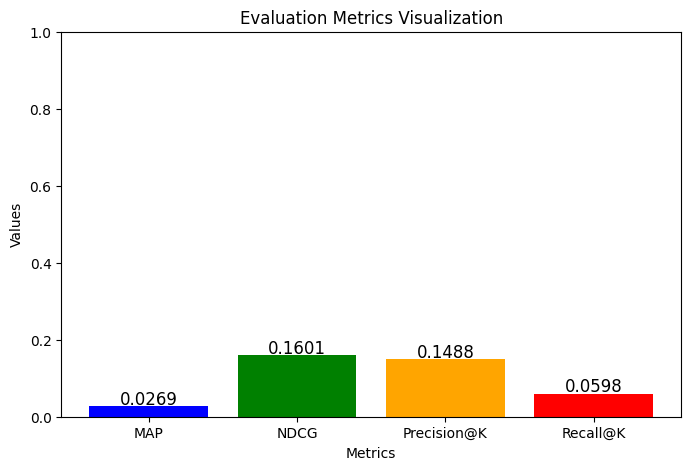

In [51]:
import matplotlib.pyplot as plt

# Danh sách các metric và giá trị tương ứng
metrics = ["MAP", "NDCG", "Precision@K", "Recall@K"]
values = [eval_map2, eval_ndcg2, eval_precision2, eval_recall2]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

# Gán nhãn cho từng cột
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=12)

plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Evaluation Metrics Visualization")
plt.ylim(0, 1)  # Các metric thường có giá trị từ 0 đến 1
plt.show()


In [53]:
model.save(dir_name="/Users/chi.nguyenth/Documents/DoAn_63133022_NguyenThiHaChi/model/ncf_model")
